<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/1d_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install -qq neural_tangents==0.2.2

In [1]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
from jax.lib import xla_bridge
import jax.numpy as np
# import neural_tangents as nt
# from neural_tangents import stax
from jax.example_libraries import stax
from jax.example_libraries import optimizers
import os

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm

import time

import numpy as onp


In [2]:
# Utils

fplot = lambda x : np.fft.fftshift(np.log10(np.abs(np.fft.fft(x))))

# Signal makers

def sample_random_signal(key, decay_vec):
  N = decay_vec.shape[0]
  raw = random.normal(key, [N, 2]) @ np.array([1, 1j])
  signal_f = raw * decay_vec
  signal = np.real(np.fft.ifft(signal_f))
  return signal




# Network 

def make_network(num_layers, num_channels, ntk_params=True, num_outputs=1):
  layers = []
  for i in range(num_layers-1):
    if ntk_params:
        layers.append(stax.Dense(num_channels))
    else:
        layers.append(stax.Dense(num_channels))
    layers.append(stax.Relu)
  layers.append(stax.Dense(num_outputs))
  return stax.serial(*layers)

# Encoding 

def compute_ntk(x, avals, bvals, kernel_fn):
    x1_enc = input_encoder(x, avals, bvals)
    x2_enc = input_encoder(np.array([0.], dtype=np.float32), avals, bvals)
    out = np.squeeze(kernel_fn(x1_enc, x2_enc, 'ntk'))
    return out


input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x[...,None]) * b), 
                                                a * np.cos((2.*np.pi*x[...,None]) * b)], axis=-1) / np.linalg.norm(a)


def predict_psnr_basic(kernel_fn, train_fx, test_fx, train_x, train_y, test_x, test_y, t_final, eta=None):  
  g_dd = kernel_fn(train_x, train_x, 'ntk')
  g_td = kernel_fn(test_x, train_x, 'ntk')
  train_predict_fn = nt.predict.gradient_descent_mse(g_dd, train_y[...,None], g_td)
  train_theory_y, test_theory_y = train_predict_fn(t_final, train_fx[...,None], test_fx[...,None])

  calc_psnr = lambda f, g: -10. * np.log10(np.mean((f-g)**2))
  return calc_psnr(test_y, test_theory_y[:,0]), calc_psnr(train_y, train_theory_y[:,0])

predict_psnr_basic = jit(predict_psnr_basic, static_argnums=(0,))


def train_model(rand_key, network_size, lr, iters, 
                train_input, test_input, test_mask, optimizer, ab, name=''):
    if ab is None:
        ntk_params = False
    else:
        ntk_params = True
    init_fn, apply_fn = make_network(*network_size, ntk_params=ntk_params)

    if ab is None:
        run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, x[...,None] - .5)))
    else:
        run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))
    model_loss = jit(lambda params, ab, x, y: .5 * np.sum((run_model(params, ab, x) - y) ** 2))
    model_psnr = jit(lambda params, ab, x, y: -10 * np.log10(np.mean((run_model(params, ab, x) - y) ** 2)))
    model_grad_loss = jit(lambda params, ab, x, y: jax.grad(model_loss)(params, ab, x, y))

    opt_init, opt_update, get_params = optimizer(lr)
    opt_update = jit(opt_update)

    if ab is None:
        _, params = init_fn(rand_key, (-1, 1))
    else:
        _, params = init_fn(rand_key, (-1, input_encoder(train_input[0], *ab).shape[-1]))
    opt_state = opt_init(params)

    pred0 = run_model(get_params(opt_state), ab, test_input[0])
    pred0_f = np.fft.fft(pred0)

    train_psnrs = []
    test_psnrs = []
    theories = []
    xs = []
    errs = []
    for i in tqdm(range(iters), desc=name):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), ab, *train_input), opt_state)

        if i % 20 == 0:
            train_psnr = model_psnr(get_params(opt_state), ab, *train_input)
            test_psnr = model_psnr(get_params(opt_state), ab, test_input[0][test_mask], test_input[1][test_mask])
            # if ab is None:
            #     train_fx = run_model(get_params(opt_state), ab, train_input[0])
            #     test_fx = run_model(get_params(opt_state), ab, test_input[0][test_mask])
            #     theory = predict_psnr_basic(kernel_fn, train_fx, test_fx, train_input[0][...,None]-.5, train_input[1], test_input[0][test_mask][...,None], test_input[1][test_mask], i*lr)
            # else:
            #     test_x = input_encoder(test_input[0][test_mask], *ab)
            #     train_x = input_encoder(train_input[0], *ab)

            #     train_fx = run_model(get_params(opt_state), ab, train_input[0])
            #     test_fx = run_model(get_params(opt_state), ab, test_input[0][test_mask])
            #     theory = predict_psnr_basic(kernel_fn, train_fx, test_fx, train_x, train_input[1], test_x, test_input[1][test_mask], i*lr)


            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            # theories.append(theory)
            pred = run_model(get_params(opt_state), ab, train_input[0])
            errs.append(pred - train_input[1])
            xs.append(i)
    return get_params(opt_state), apply_fn, train_psnrs, test_psnrs, errs, np.array(theories), xs

# Make fig 2

In [3]:
N_train = 500
data_power = 1

network_size = (4, 1024)

learning_rate = 1e-3
sgd_iters = 6000



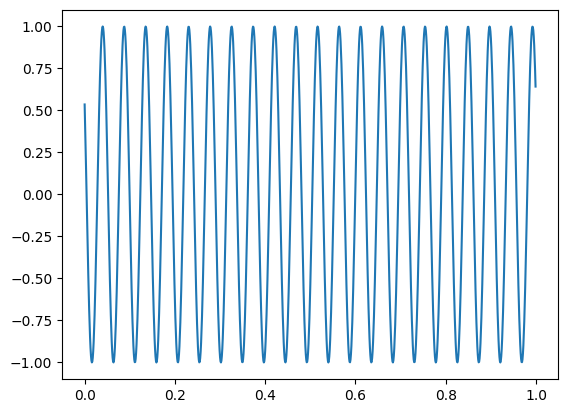

In [4]:
def sample_random_powerlaw(key, N, power):
  coords = np.float32(np.fft.ifftshift(1 + N//2 - np.abs(np.fft.fftshift(np.arange(N)) - N//2)))
  decay_vec = coords ** -power
  decay_vec = onp.array(decay_vec)
  decay_vec[N//4:] = 0
  return sample_random_signal(key, decay_vec)

def sinusoid(x, freq):
  return np.sin(2 * np.pi * freq * (x + 0.21))

rand_key = random.PRNGKey(42)
subkey, subkey2 = random.split(rand_key)




M = 2
N = N_train

s = sinusoid(np.linspace(0,1.,N*M,endpoint=False), 21)
# s2 = sinusoid(np.linspace(0,1.,N*M//2,endpoint=False), 5)
#merge s and s2
# s = np.concatenate([s2, s2])

# s = s.reshape(N,M)
# s.shape
# plt.plot(s)
x_test = np.float32(np.linspace(0,1.,N*M,endpoint=False))
# x_train = x_test[::M]
# s = (s-s.min()) / (s.max()-s.min()) - .5
plt.plot(x_test, s)

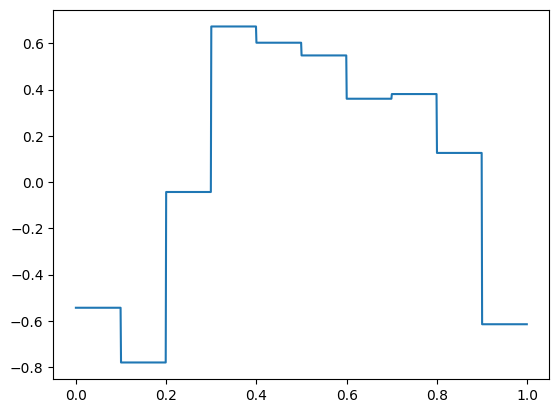

In [5]:
class RandomSignal:
  """ Generate a signal with a domain N given number of regions with random values.
      For each region, the signal value is a random number between -1 and 1."""
  def __init__(self, N, regions) -> None:
      self.N = N
      self.regions = regions
      self.region_size = N // regions
      self.region_values = random.uniform(subkey, (regions,), minval=-1, maxval=1)

  def get_value(self, x):
    x = np.int32(((x/self.N) * self.regions) % self.regions)
    return self.region_values[x]

signal = RandomSignal(1.0, 10)
s = signal.get_value(np.linspace(0,1.,N*M,endpoint=False))
plt.plot(x_test, s)


In [6]:
rand_key = random.PRNGKey(0)

config.update('jax_disable_jit', False)

# Signal
M = 8
N = N_train
x_test = np.float32(np.linspace(0,1.,N*M,endpoint=False))
x_train = x_test[::M]

test_mask = onp.ones(len(x_test), bool)
test_mask[np.arange(0,x_test.shape[0],M)] = 0

# s = sample_random_powerlaw(rand_key, N*M, data_power) 
# s = (s-s.min()) / (s.max()-s.min()) - .5
s = sinusoid(np.linspace(0,1.,N*M//2,endpoint=False), 0.3)
s2 = sinusoid(np.linspace(0,1.,N*M//2,endpoint=False), 30)
# s = sinusoid(np.linspace(0,1.,N*M,endpoint=False), 5)

#merge s and s2
s = np.concatenate([s, s2])

# signal = RandomSignal(1.0, 250)
# s = signal.get_value(np.linspace(0,1.,N*M,endpoint=False))

# Kernels
# bvals = np.float32(np.arange(1, N//2+1))
g = 10
bvals = 1/((1/(50))*g**np.arange(0, 3))
# bvals = 1/((1/(12))*g**np.arange(0, 9))
# high_freq = np.abs(random.normal(rand_key, [1024]) * 10)
# print(bvals)

ab_dict = {}
# ab_dict = {r'$p = {}$'.format(p) : (bvals**-np.float32(p), bvals) for p in [0, 1]}
ab_dict = {r'$p = {}$'.format(p) : (bvals**-np.float32(p), bvals) for p in [0]}
# ab_dict[r'$p = \infty$'] = (np.eye(bvals.shape[0])[0], bvals)
# ab_dict['No mapping'] = None


# Train the networks
# rand_key, *ensemble_key = random.split(rand_key, len(ab_dict))

outputs = {k : train_model(rand_key, network_size, learning_rate, sgd_iters, 
                           (x_train, s[::M]), (x_test, s), test_mask,
                           optimizer=optimizers.sgd, ab=ab_dict[k], name=k) for k in ab_dict}

# ab_dict.update({r'$p = {}$'.format(p) : (bvals**-np.float32(p), bvals) for p in [0.5, 1.5, 2]})

$p = 0$:   0%|          | 0/3000 [00:00<?, ?it/s]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [7]:
outputs['$p = 0$'][2][-1], outputs['$p = 0$'][3][-1]
# outputs['No mapping'][2][-1], outputs['No mapping'][3][-1]

(Array(18.326448, dtype=float32), Array(8.268472, dtype=float32))

In [21]:
bvals

Array([64.       , 23.544285 ,  8.661459 ,  3.1863728,  1.172201 ,
        0.4312287], dtype=float32, weak_type=True)

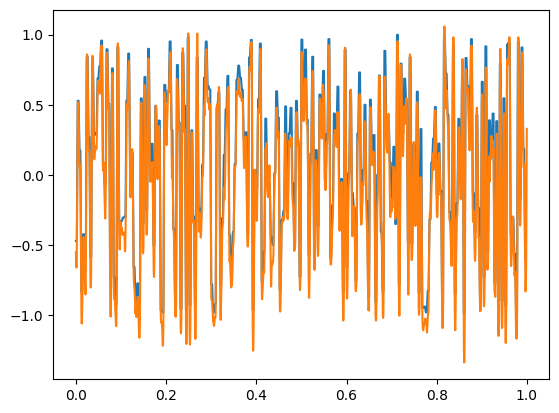

In [9]:
# run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))
p = 0
res2 = outputs[f'$p = {p}$'][1](outputs[f'$p = {p}$'][0], input_encoder(x_test, *ab_dict[f'$p = {p}$']))
# res = outputs['No mapping'][1](outputs['No mapping'][0], x_test[...,None] - .5)

# len(x_test)
plt.plot(x_train, s[::M])
# s[::M]
plt.plot(x_test, res2)
# plt.plot(x_test, res)x
# plt.plot(x_test, s)

In [6]:
def progression(m, max = 50):
    omega = np.arange(m) / (m - 1)
    omega = 1 / (max ** omega)
    return omega * max

progression(4)

Array([50.       , 13.572088 ,  3.6840312,  1.       ], dtype=float32)

In [15]:
for i in range(3, 10):
    print(i, (1/progression(i, max=150)[1])/(1/progression(i,max=150)[0]))


3 12.247449
4 5.3132935
5 3.4996352
6 2.72407
7 2.3050585
8 2.045833
9 1.8707312


In [11]:
n = 300
x_test2 = np.arange(n)/n
y = random.uniform(rand_key, (len(x_test2),), minval=-1, maxval=1)
test_mask = onp.ones(len(x_test2), bool)


ab_dict = {}
# ab_dict = {r'$p = {}$'.format(p) : (bvals**-np.float32(p), bvals) for p in [0, 1]}
# ab_dict = {r'$p = {}$'.format(p) : (bvals**-np.float32(p), bvals) for p in [0]}
# ab_dict[r'$p = \infty$'] = (np.eye(bvals.shape[0])[0], bvals)
ab_dict = {r'$m = {}$'.format(m) : (progression(m)**-np.float32(0), progression(m, max=n//2)) 
        #    for m in [5]}
           for m in [3, 4, 5, 6, 7, 8, 9, 10]}
        
# ab_dict['No mapping'] = None


# Train the networks
# rand_key, *ensemble_key = random.split(rand_key, len(ab_dict))

outputs = {k : train_model(rand_key, network_size, learning_rate, sgd_iters, 
                           (x_test2, y), (x_test2, y), test_mask,
                           optimizer=optimizers.sgd, ab=ab_dict[k], name=k) for k in ab_dict}

$m = 3$:   0%|          | 0/6000 [00:00<?, ?it/s]

$m = 4$:   0%|          | 0/6000 [00:00<?, ?it/s]

$m = 5$:   0%|          | 0/6000 [00:00<?, ?it/s]

$m = 6$:   0%|          | 0/6000 [00:00<?, ?it/s]

$m = 7$:   0%|          | 0/6000 [00:00<?, ?it/s]

$m = 8$:   0%|          | 0/6000 [00:00<?, ?it/s]

$m = 9$:   0%|          | 0/6000 [00:00<?, ?it/s]

$m = 10$:   0%|          | 0/6000 [00:00<?, ?it/s]

In [16]:
# outputs['$p = 0$'][2][-1], outputs['$p = 0$'][3][-1]
# outputs['No mapping'][2][-1], outputs['No mapping'][3][-1]
for k in ab_dict:
    print(k, outputs[k][2][-1])

$m = 3$ 18.88605
$m = 4$ 88.37424
$m = 5$ 119.51323
$m = 6$ 124.07229
$m = 7$ 128.87
$m = 8$ 123.38009
$m = 9$ 132.85503
$m = 10$ 128.5436


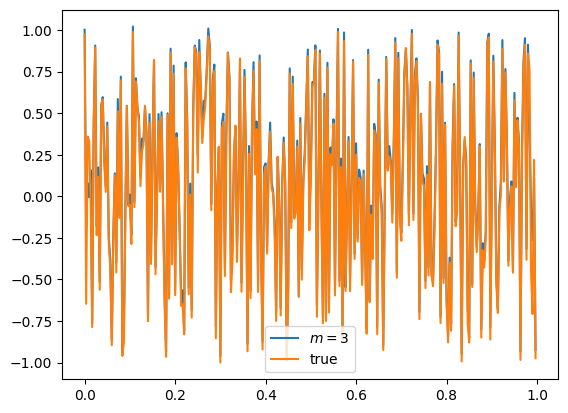

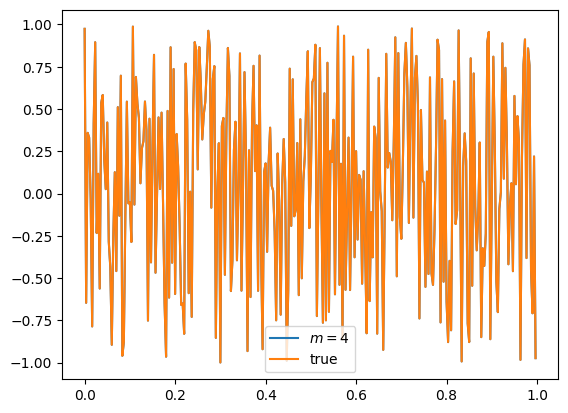

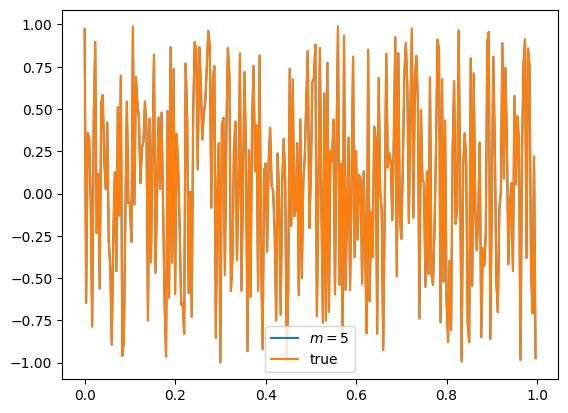

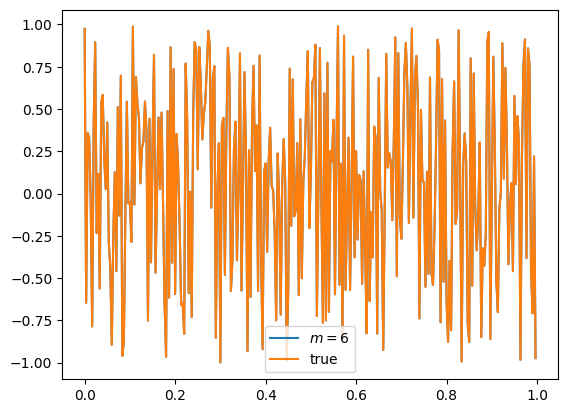

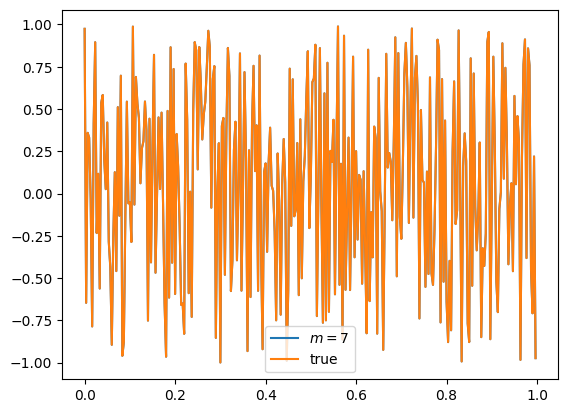

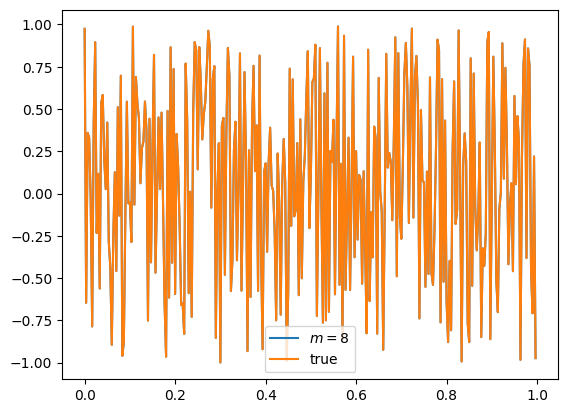

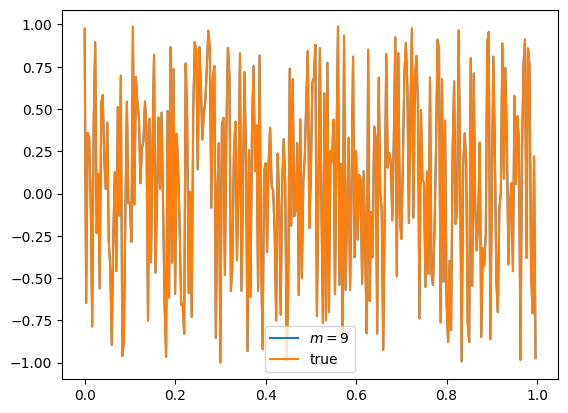

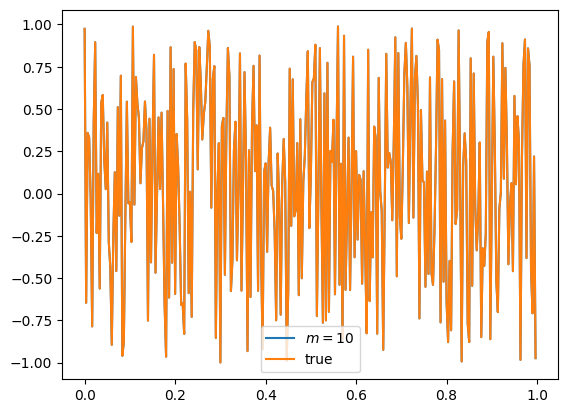

In [13]:
# run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))
# p = 0
# res2 = outputs[f'$p = {p}$'][1](outputs[f'$p = {p}$'][0], input_encoder(x_test, *ab_dict[f'$p = {p}$']))
# res = outputs['No mapping'][1](outputs['No mapping'][0], x_test2[...,None] - .5)

for k in ab_dict:
    res = outputs[k][1](outputs[k][0], input_encoder(x_test2, *ab_dict[k]))
    plt.plot(x_test2, res, label=k)
    plt.plot(x_test2, y, label='true')
    plt.legend()
    plt.show()
# len(x_test)
# s[::M]
# plt.plot(x_test2, res)
# # plt.plot(x_test, res)
# plt.plot(x_test2, y)

# Fig 2

In [27]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


params = {'legend.fontsize': 24,
         'axes.labelsize': 22,
         'axes.titlesize': 26,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"
names = ['$p = 0$', 
         '$p = 0.5$',
         '$p = 1$',
         '$p = 1.5$',
         '$p = 2$',
         '$p = \\infty$']

N_kernels = len(names)

colors_k = np.array([[0.8872, 0.4281, 0.1875],
    [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 3
line_alpha = .8
title_offset = -0.3

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

init_fn, apply_fn, kernel_fn = make_network(*network_size)
run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))

fig3 = plt.figure(constrained_layout=True, figsize=(22,4))
gs = fig3.add_gridspec(1, 4, width_ratios=[1,1,1.3,1.3])

### Plot NTK stuff

H_rows = {k : compute_ntk(x_train, *ab_dict[k], kernel_fn) for k in names}

samples = 100
x_no_encoding = np.linspace(-np.pi, np.pi, samples)
x_basic = np.stack([np.sin(x_no_encoding),np.cos(x_no_encoding)], axis=-1)
relu_NTK = kernel_fn(x_no_encoding[:,None], x_no_encoding[:,None], 'ntk')
basic_NTK = kernel_fn(x_basic, x_basic, 'ntk')

ax = fig3.add_subplot(gs[0, 0])
ax.imshow(relu_NTK, cmap='inferno', extent=[-.5,.5,.5,-.5])
ax.xaxis.tick_top()
extent = [-.5,.5]
ax.set_xticks([-.5,.5])
ax.set_yticks([-.5,.5])
ax.set_xticklabels([fr'${t:g}$' for t in extent])
ax.set_yticklabels([fr'${t:g}$' for t in extent])
xtick = ax.get_xticks()
ax.set_xticks(xtick)
ax.set_xticklabels([fr'${t:g}$' for t in xtick])
ax.set_title('(a) No mapping NTK', y=title_offset)

ax = fig3.add_subplot(gs[0, 1])
ax.imshow(basic_NTK, cmap='inferno', extent=[-.5,.5,.5,-.5])
ax.xaxis.tick_top()
ax.set_xticks([-.5,.5])
ax.set_yticks([-.5,.5])
ax.set_xticklabels([fr'${t:g}$' for t in extent])
ax.set_yticklabels([fr'${t:g}$' for t in extent])
ax.set_title('(b) Basic mapping NTK', y=title_offset)

ax = fig3.add_subplot(gs[0, 2])
for c, k in zip(colors_k, H_rows):
  ntk_spatial = np.fft.fftshift(H_rows[k])
  ax.plot(np.linspace(-.5, .5, 33, endpoint=True), np.append(ntk_spatial, ntk_spatial[0]), label=k, color=c, alpha=line_alpha, linewidth=linewidth)
ax.set_title('(c) NTK spatial', y=title_offset)
xtick = ax.get_xticks()
ax.set_xticks(xtick)
ax.set_xticklabels([fr'${t:g}$' for t in xtick])

plt.grid(True, which='both', alpha=.3)
plt.autoscale(enable=True, axis='x', tight=True)

ax = fig3.add_subplot(gs[0, 3])
for c, k in zip(colors_k, H_rows):
  ntk_spectrum = 10**fplot(H_rows[k])
  plt.semilogy(np.append(ntk_spectrum, ntk_spectrum[0]), label=k, color=c, alpha=line_alpha, linewidth=linewidth)
ax.set_title('(d) NTK Fourier spectrum', y=title_offset)
plt.xticks([0,8,16,24,32], ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$'])

plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(True, which='major', alpha=.3)
plt.legend(loc='center left', bbox_to_anchor=(1,.5), handlelength=1)


plt.savefig('1D_fig2.pdf', bbox_inches='tight', pad_inches=0)

plt.show()



KeyError: '$p = 0$'

# Fig 3

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5487: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


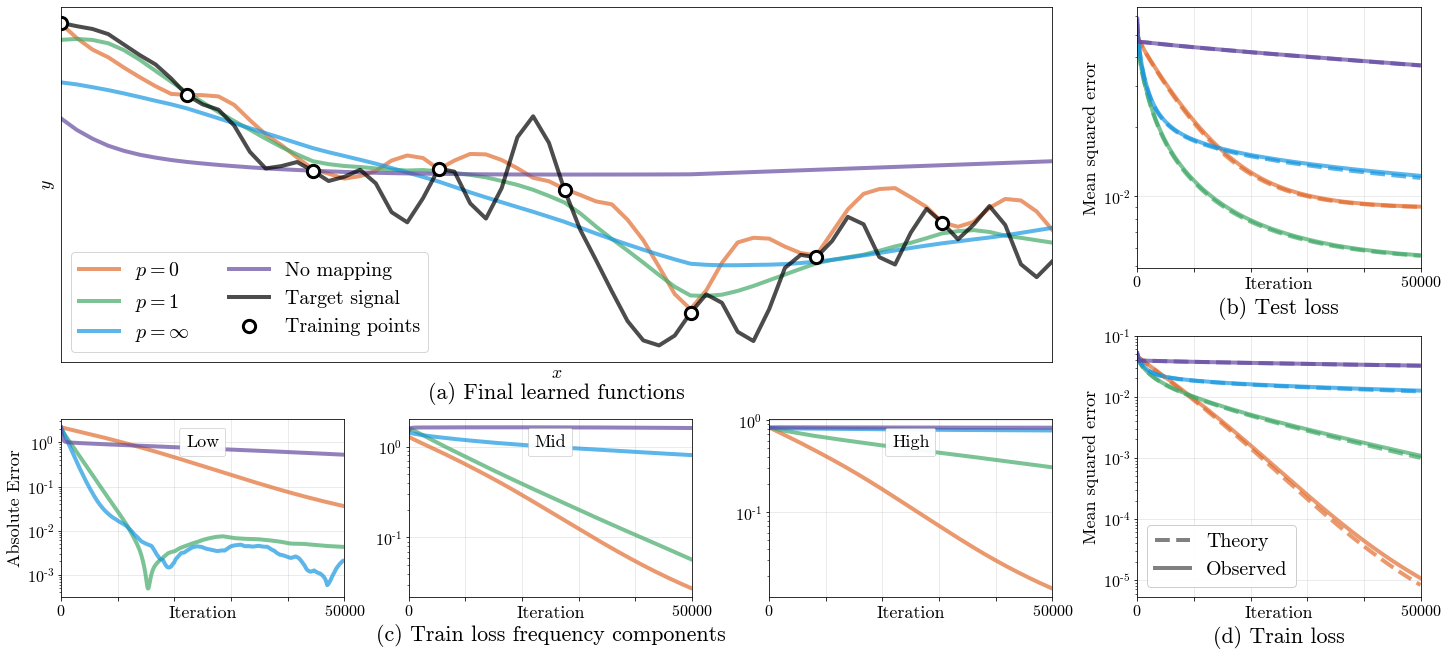

In [ ]:
import matplotlib.patches as patches

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 20,
         'axes.labelsize': 18,
         'axes.titlesize': 22,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"

names = list(outputs.keys())
names = [n for n in names if 'opt' not in n]
names = [
         '$p = 0$', 
        #  '$p = 0.5$',
         '$p = 1$',
        #  '$p = 1.5$',
        #  '$p = 2$',
         '$p = \\infty$',
         'No mapping'
         ]

N_kernels = len(names)
colors_k = np.array([[0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 4
line_alpha = .7
title_offset = -0.2

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

_, apply_fn, kernel_fn = make_network(*network_size)
_, apply_fn_standard, kernel_fn_standard = make_network(*network_size, ntk_params=False)
run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))

fig3 = plt.figure(constrained_layout=True, figsize=(20,9))
gs = fig3.add_gridspec(6, 8)

H_rows = {k : compute_ntk(x_train, *ab_dict[k], kernel_fn) for k in names if k not in 'No mapping'}


### Plot learned fns
max_size = x_test.shape[0]
i0, i1 = 0.5, .75  ### These numbers are arbitrary, just taking a slice
i0 = (int(max_size * i0)//M)*M
i1 = (int(max_size * i1)//M)*M
ax = fig3.add_subplot(gs[0:4, 0:6])
for c, k in zip(colors_k, names):
  params = outputs[k][0]
  if k in 'No mapping':
      ax.plot(x_test[i0:i1], apply_fn_standard(params, x_test[..., None]-.5)[i0:i1], label=k, color=c, linewidth=linewidth, alpha=line_alpha, zorder=1)
  else:
    ax.plot(x_test[i0:i1], run_model(params, ab_dict[k], x_test)[i0:i1], label=k, color=c, linewidth=linewidth, alpha=line_alpha, zorder=1)

plt.plot(x_test[i0:i1], s[i0:i1], label='Target signal', color='k', linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.autoscale(enable=True, axis='x', tight=True)
ax.scatter(x_train[i0//M:i1//M], s[i0:i1:M], color='w', edgecolors='k', linewidths=2, s=150, linewidth=3, label='Training points', zorder=2)
ax.set_title('(a) Final learned functions', y=title_offset+.08)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='lower left', ncol=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True, which='both', alpha=.3)

### Plot loss curves

xvals = xs # np.log10(np.array(xs))
ax = fig3.add_subplot(gs[3:6, 6:8])
for c, k in zip(colors_k, names):
  ax.semilogy(xvals, 10**(np.array(outputs[k][1])/-10), color=c, label=k, alpha=line_alpha, linewidth=linewidth)
#   if k in 'no encoding':
#       continue
  ax.semilogy(xvals, 10**(np.array(outputs[k][4][:,1])/-10), '--', color=c, alpha=line_alpha, linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax.set_xticklabels(['$0$','','','','','$50000$'])
plt.xlabel('Iteration', labelpad=-13)
plt.ylabel('Mean squared error')
plt.xlabel('Iteration')
ax.set_title('(d) Train loss', y=title_offset)
ax.set_ylim(top=.1)
plt.grid(True, which='major', alpha=.3)
custom_lines = [Line2D([], [], color='gray', linestyle='--', linewidth=linewidth),
                Line2D([], [], color='gray', linestyle='-', linewidth=linewidth)]
ax.legend(custom_lines, ['Theory', 'Observed'], loc='lower left',  ncol=1, framealpha=.95, handlelength=1.75)

ax = fig3.add_subplot(gs[0:3, 6:8])
for c, k in zip(colors_k, names):
  ax.semilogy(xvals, 10**(np.array(outputs[k][2])/-10), color=c, label=k, alpha=line_alpha, linewidth=linewidth)
  ax.semilogy(xvals, 10**(np.array(outputs[k][4][:,0])/-10), '--', color=c, alpha=line_alpha, linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax.set_xticklabels(['$0$','','','','','$50000$'])
plt.xlabel('Iteration', labelpad=-13)
plt.ylabel('Mean squared error')
plt.xlabel('Iteration')
ax.set_title('(b) Test loss', y=title_offset)
ax.set_yticklabels([], minor=True)
plt.grid(True, which='major', alpha=.3)


### Plot freq components
letters = ['f','g','h']
prefix = ['Low', 'Mid', 'High']
for i, j in enumerate([1, 5, 15]):
  err_lines = {k : np.abs(np.fft.fft(np.array(outputs[k][3]))[:,j]) for k in names}
  ax = fig3.add_subplot(gs[4:6, 0+2*i:0+2*i+2])
  for c, k in zip(colors_k, err_lines):
    ax.semilogy(xs, err_lines[k], label=k, color=c, alpha=line_alpha, linewidth=linewidth)
  plt.autoscale(enable=True, axis='x', tight=True)
  props = dict(boxstyle='round,pad=0.35,rounding_size=.1', facecolor='white', edgecolor='gray', linewidth=.3, alpha=0.95)
  plt.text(0.5, 0.87, prefix[i], horizontalalignment='center', 
           verticalalignment='center', transform=ax.transAxes, bbox=props, fontsize=18)
  if i == 0:
      plt.ylabel('Absolute Error')
  if i == 1:
    ax.set_title(f'(c) Train loss frequency components', y=title_offset-.08)
  ax.set_xticks([0,10000,20000,30000,40000,50000])
  ax.set_xticklabels(['$0$','','','','','$50000$'])
  plt.xlabel('Iteration', labelpad=-13)
  ax.set_yticklabels([], minor=True)
  plt.grid(True, which='major', alpha=.3)

plt.savefig('1D_fig2_5.pdf', bbox_inches='tight', pad_inches=0)

plt.show()



# Supp (fig 3 expanded)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5487: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


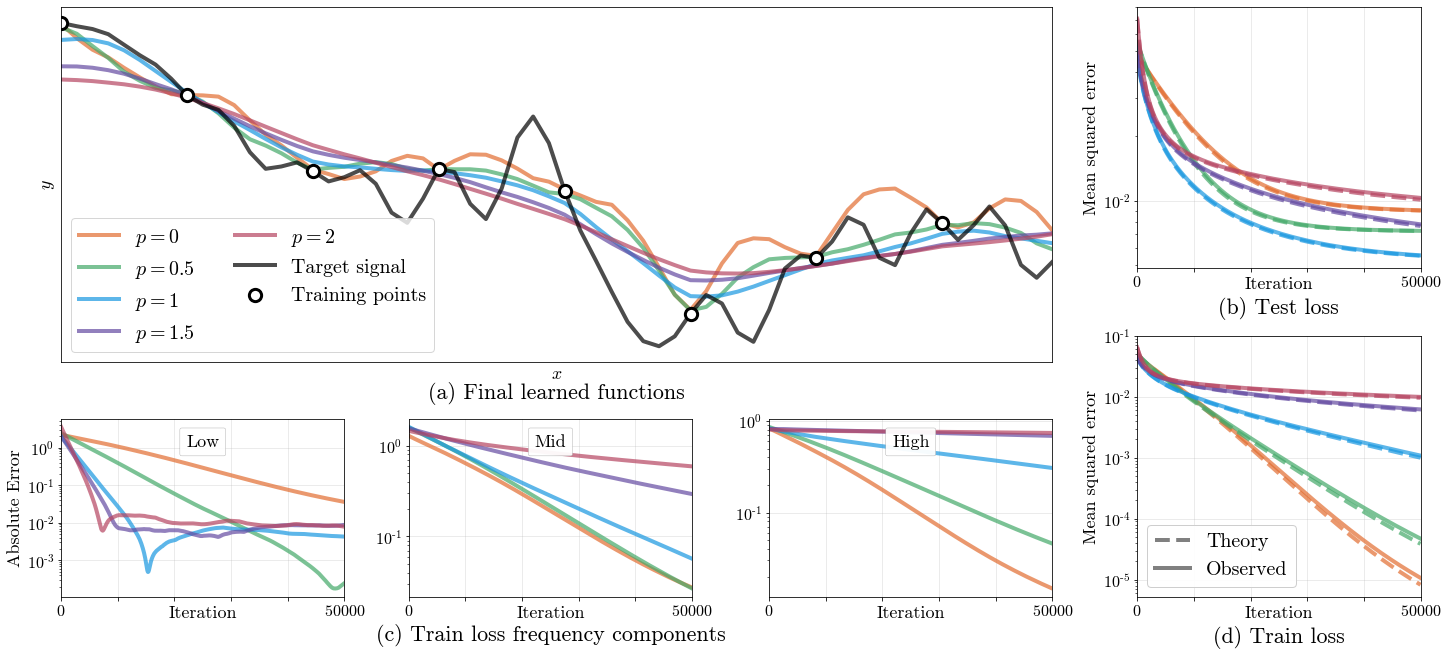

In [ ]:
import matplotlib.patches as patches

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 20,
         'axes.labelsize': 18,
         'axes.titlesize': 22,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"

names = list(outputs.keys())
names = [n for n in names if 'opt' not in n]
names = [
         '$p = 0$', 
         '$p = 0.5$',
         '$p = 1$',
         '$p = 1.5$',
         '$p = 2$',
         '$p = \\infty$',
         'No mapping'
         ]

N_kernels = len(names)
colors_k = np.array([[0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 4
line_alpha = .7
title_offset = -0.2

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

_, apply_fn, kernel_fn = make_network(*network_size)
_, apply_fn_standard, kernel_fn_standard = make_network(*network_size, ntk_params=False)
run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))

fig3 = plt.figure(constrained_layout=True, figsize=(20,9))
gs = fig3.add_gridspec(6, 8)

H_rows = {k : compute_ntk(x_train, *ab_dict[k], kernel_fn) for k in names if k not in 'No mapping'}


### Plot learned fns
max_size = x_test.shape[0]
i0, i1 = 0.5, .75  ### These numbers are arbitrary, just taking a slice
i0 = (int(max_size * i0)//M)*M
i1 = (int(max_size * i1)//M)*M
ax = fig3.add_subplot(gs[0:4, 0:6])
for c, k in zip(colors_k, names):
  params = outputs[k][0]
  if k in 'No mapping':
      ax.plot(x_test[i0:i1], apply_fn_standard(params, x_test[..., None]-.5)[i0:i1], label=k, color=c, linewidth=linewidth, alpha=line_alpha, zorder=1)
  else:
    ax.plot(x_test[i0:i1], run_model(params, ab_dict[k], x_test)[i0:i1], label=k, color=c, linewidth=linewidth, alpha=line_alpha, zorder=1)

plt.plot(x_test[i0:i1], s[i0:i1], label='Target signal', color='k', linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.autoscale(enable=True, axis='x', tight=True)
ax.scatter(x_train[i0//M:i1//M], s[i0:i1:M], color='w', edgecolors='k', linewidths=2, s=150, linewidth=3, label='Training points', zorder=2)
ax.set_title('(a) Final learned functions', y=title_offset+.08)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='lower left', ncol=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True, which='both', alpha=.3)

### Plot loss curves

xvals = xs # np.log10(np.array(xs))
ax = fig3.add_subplot(gs[3:6, 6:8])
for c, k in zip(colors_k, names):
  ax.semilogy(xvals, 10**(np.array(outputs[k][1])/-10), color=c, label=k, alpha=line_alpha, linewidth=linewidth)
#   if k in 'no encoding':
#       continue
  ax.semilogy(xvals, 10**(np.array(outputs[k][4][:,1])/-10), '--', color=c, alpha=line_alpha, linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax.set_xticklabels(['$0$','','','','','$50000$'])
plt.xlabel('Iteration', labelpad=-13)
plt.ylabel('Mean squared error')
plt.xlabel('Iteration')
ax.set_title('(d) Train loss', y=title_offset)
ax.set_ylim(top=.1)
plt.grid(True, which='major', alpha=.3)
custom_lines = [Line2D([], [], color='gray', linestyle='--', linewidth=linewidth),
                Line2D([], [], color='gray', linestyle='-', linewidth=linewidth)]
ax.legend(custom_lines, ['Theory', 'Observed'], loc='lower left',  ncol=1, framealpha=.95, handlelength=1.75)

ax = fig3.add_subplot(gs[0:3, 6:8])
for c, k in zip(colors_k, names):
  ax.semilogy(xvals, 10**(np.array(outputs[k][2])/-10), color=c, label=k, alpha=line_alpha, linewidth=linewidth)
  ax.semilogy(xvals, 10**(np.array(outputs[k][4][:,0])/-10), '--', color=c, alpha=line_alpha, linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax.set_xticklabels(['$0$','','','','','$50000$'])
plt.xlabel('Iteration', labelpad=-13)
plt.ylabel('Mean squared error')
plt.xlabel('Iteration')
ax.set_title('(b) Test loss', y=title_offset)
ax.set_yticklabels([], minor=True)
plt.grid(True, which='major', alpha=.3)


### Plot freq components
letters = ['f','g','h']
prefix = ['Low', 'Mid', 'High']
for i, j in enumerate([1, 5, 15]):
  err_lines = {k : np.abs(np.fft.fft(np.array(outputs[k][3]))[:,j]) for k in names}
  ax = fig3.add_subplot(gs[4:6, 0+2*i:0+2*i+2])
  for c, k in zip(colors_k, err_lines):
    ax.semilogy(xs, err_lines[k], label=k, color=c, alpha=line_alpha, linewidth=linewidth)
  plt.autoscale(enable=True, axis='x', tight=True)
  props = dict(boxstyle='round,pad=0.35,rounding_size=.1', facecolor='white', edgecolor='gray', linewidth=.3, alpha=0.95)
  plt.text(0.5, 0.87, prefix[i], horizontalalignment='center', 
           verticalalignment='center', transform=ax.transAxes, bbox=props, fontsize=18)
  if i == 0:
      plt.ylabel('Absolute Error')
  if i == 1:
    ax.set_title(f'(c) Train loss frequency components', y=title_offset-.08)
  ax.set_xticks([0,10000,20000,30000,40000,50000])
  ax.set_xticklabels(['$0$','','','','','$50000$'])
  plt.xlabel('Iteration', labelpad=-13)
  ax.set_yticklabels([], minor=True)
  plt.grid(True, which='major', alpha=.3)

plt.savefig('1D_fig_supp.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

